In [1]:
# Import librairies
import matplotlib.pyplot as plt
from transformers import BertModel, BertTokenizer
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from typing import TypedDict, List

In [2]:
##### Setup classes ####
class EmbeddingModel(TypedDict):
    name: str
    tokenizer: BertTokenizer
    model: BertModel

class EmbeddingModelResult(TypedDict):
    model_name: str
    weat_score: float

class ExperimentSetup(TypedDict):
    name: str
    A1: List[str]
    A2: List[str]
    W1: List[str]
    W2: List[str]

class ExperimentResult(TypedDict):
    name: str
    results: List[EmbeddingModelResult]

In [3]:
######## Useful functions #########
def encode_word_list(word_list: List[str], tokenizer, model):
    tokenized_words = tokenizer.batch_encode_plus(word_list, return_tensors="pt", padding=True)
    with torch.no_grad():
        outputs = model(**tokenized_words)

    last_hidden_state = outputs.last_hidden_state
    word_embeddings = last_hidden_state[:, 0, :].numpy()
    embedding_dict = dict()
    for word, embedding in zip(word_list, word_embeddings):
        embedding_dict[word] = embedding
    
    return embedding_dict
    
    
def calculate_association(target_word, W1, W2, embedding_dict): ## function to conpute s(a, W1, W2)
    """
    Calculate the association between a target word and two attribute sets W1 and W2.
    This returns the difference between the mean cosine similarities of the target word
    to W1 and the target word to W2.
    """
    target_embedding = embedding_dict[target_word]

    # Cosine similarities with W1
    similarities_w1 = []
    for word in W1:
        word_embedding = embedding_dict[word]
        similarity = cosine_similarity([target_embedding], [word_embedding])[0][0]
        similarities_w1.append(similarity)
        
    # Cosine similarities with W2
    similarities_w2 = []
    for word in W2:
        word_embedding = embedding_dict[word]
        similarity = cosine_similarity([target_embedding], [word_embedding])[0][0]
        similarities_w2.append(similarity)
        
    # s(a, W1, W2) = mean(cos(a, w1)) - mean(cos(a, w2))
    return np.mean(similarities_w1) - np.mean(similarities_w2)


def run_weat_test(A1, A2, W1, W2, embedding_dict):  ### Compute WEAT(A1, A2, W1, W2); the range is (-2, 2)
    """
    Run a WEAT-like test comparing target word sets A1 and A2 with attribute word sets W1 and W2.
    The function computes the WEAT effect size, which is a measure of bias.
    """
    A1_similarities = [calculate_association(a1, W1, W2, embedding_dict) for a1 in A1]
    A2_similarities = [calculate_association(a2, W1, W2, embedding_dict) for a2 in A2]
    mean_A1 = np.mean(A1_similarities)
    mean_A2 = np.mean(A2_similarities)
    combined_similarities = A1_similarities + A2_similarities # this is to compute the standard deviation of the union
    effect_size = (mean_A1 - mean_A2) / np.std(combined_similarities)

    return effect_size


def run_experiment(experiment_setup: ExperimentSetup, embedding_model_list : List[EmbeddingModel]) -> List[EmbeddingModelResult]:
    total_word_list = experiment_setup["A1"] + experiment_setup["A2"] + experiment_setup["W1"] + experiment_setup["W2"]

    all_model_results = list()

    for embedding_model in embedding_model_list:
        embedding_dict = encode_word_list(total_word_list, embedding_model["tokenizer"], embedding_model["model"])
        effect_size = run_weat_test(experiment_setup["A1"], experiment_setup["A2"], experiment_setup["W1"], experiment_setup["W2"], embedding_dict)
        model_result:EmbeddingModelResult = {
            "model_name": embedding_model["name"],
            "weat_score": effect_size
        }

        all_model_results.append(model_result)

    return  all_model_results


In [4]:
############ LLMs models used #################
# 1- Load pre-trained BERT model and tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# 2- Load pre-trained SciBERT model and tokenizer
scibert_tokenizer = BertTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
scibert_model = BertModel.from_pretrained('allenai/scibert_scivocab_uncased')

embedding_models: List[EmbeddingModel] = [
    {
        "name": "BERT",
        "tokenizer": bert_tokenizer,
        "model": bert_model
    },
    {
        "name": "SciBERT",
        "tokenizer": scibert_tokenizer,
        "model": scibert_model
    }
]

## Different experiments

In [5]:
################ Researcher vs Failure ################
experiment_list: List[ExperimentSetup] = [

    {
        "name":"gender_bias",
        "A1": ["John", "Paul", "Mike", "Kevin", "Steve", "Greg", "Jeff", "Bill"],
        "A2": ["Amy", "Joan", "Lisa", "Sarah", "Diana", "Kate", "Ann", "Donna"],
        "W1": ["Researcher", "Academia", "Award", "Funding", "PhD", "Doctor", "Affiliation", "Keynote",
      "Cited", "Prize", "Professor", "University", "Successful", "Nobel", "Scholar", "Scientist",
      "Investigator", "Tenure", "Expert"],
        "W2": ["Misconduct", "Academic dismissal", "Retraction", "Grant rejection", "Dropout", "Impostor",
      "Disaffiliation", "Denial", "Plagiarism", "Fraud", "De-tenuring", "Expulsion", "Failed experiment",
      "Scandal", "Pseudoscience", "Quack", "Misconduct investigation", "Tenure denial", "Discredited"]
    },
    {
        "name": "race_bias",
        "A1": ["Brad", "Brendan", "Geoffrey", "Greg", "Brett", "Jay", "Matthew", "Neil", "Todd", "Allison", "Anne", "Carrie", "Emily", "Jill", "Laurie", "Kristen", "Meredith", "Sarah"],
        "A2": ["Darnell", "Hakim", "Jermaine", "Kareem", "Jamal", "Leroy", "Rasheed", "Tremayne", "Tyrone", "Aisha", "Ebony", "Keisha", "Kenya", "Latonya", "Lakisha", "Latoya", "Tamika", "Tanisha"],
        "W1": ["Researcher", "Academia", "Award", "Funding", "PhD", "Doctor", "Affiliation", "Keynote",
      "Cited", "Prize", "Professor", "University", "Successful", "Nobel", "Scholar", "Scientist",
      "Investigator", "Tenure", "Expert"],
        "W2": ["Misconduct", "Academic dismissal", "Retraction", "Grant rejection", "Dropout", "Impostor",
      "Disaffiliation", "Denial", "Plagiarism", "Fraud", "De-tenuring", "Expulsion", "Failed experiment",
      "Scandal", "Pseudoscience", "Quack", "Misconduct investigation", "Tenure denial", "Discredited"]
    },
    {
        "name": "Field_bias",
        "A1": ["science", "technology", "physics", "chemistry", "Einstein", "NASA", "experiment", "astronomy"],

        "A2": ["poetry", "art", "Shakespeare", "dance", "literature", "novel", "symphony", "drama"],

        "W1": ["Researcher", "Academia", "Award", "Funding", "PhD", "Doctor", "Affiliation", "Keynote",
      "Cited", "Prize", "Professor", "University", "Successful", "Nobel", "Scholar", "Scientist",
      "Investigator", "Tenure", "Expert"],
        "W2": ["Misconduct", "Academic dismissal", "Retraction", "Grant rejection", "Dropout", "Impostor",
      "Disaffiliation", "Denial", "Plagiarism", "Fraud", "De-tenuring", "Expulsion", "Failed experiment",
      "Scandal", "Pseudoscience", "Quack", "Misconduct investigation", "Tenure denial", "Discredited"]
    },
    {
        "name": "Location_bias",
        "A1": ["United States", "Canada", "Germany", "United Kingdom", "France", "Japan", "Norway", "Sweden", "Australia", "New Zealand"],

        "A2": ["Brazil", "India", "South Africa", "Mexico", "Argentina", "Nigeria", "Indonesia", "Kenya", "Vietnam", "Philippines"],



        "W1": ["Researcher", "Academia", "Award", "Funding", "PhD", "Doctor", "Affiliation", "Keynote",
      "Cited", "Prize", "Professor", "University", "Successful", "Nobel", "Scholar", "Scientist",
      "Investigator", "Tenure", "Expert"],
        "W2": ["Misconduct", "Academic dismissal", "Retraction", "Grant rejection", "Dropout", "Impostor",
      "Disaffiliation", "Denial", "Plagiarism", "Fraud", "De-tenuring", "Expulsion", "Failed experiment",
      "Scandal", "Pseudoscience", "Quack", "Misconduct investigation", "Tenure denial", "Discredited"]

    },

    {
        "name": "Prestige_bias",
        "A1": ["Harvard University", "Massachusetts Institute of Technology (MIT)", "Oxford University",
                       "Stanford University", "California Institute of Technology (Caltech)", "Cambridge University",
                       "Yale University", "Princeton University", "University of Tokyo", "ETH Zurich"],


        "A2": ["University of Cape Coast", "University of Dhaka", "Federal University of Lavras",
                           "Brock University", "Jamia Millia Islamia University", "Ateneo de Manila University",
                           "Pontifical Catholic University of Peru", "Bilkent University",
                           "University of Dschang", "Universidad de los Andes"],



        "W1": ["Researcher", "Academia", "Award", "Funding", "PhD", "Doctor", "Affiliation", "Keynote",
      "Cited", "Prize", "Professor", "University", "Successful", "Nobel", "Scholar", "Scientist",
      "Investigator", "Tenure", "Expert"],
        "W2": ["Misconduct", "Academic dismissal", "Retraction", "Grant rejection", "Dropout", "Impostor",
      "Disaffiliation", "Denial", "Plagiarism", "Fraud", "De-tenuring", "Expulsion", "Failed experiment",
      "Scandal", "Pseudoscience", "Quack", "Misconduct investigation", "Tenure denial", "Discredited"]

    },
    {
        "name": "Socioeconomic_bias",

      "A1": [
        "Wealthy", "Privileged", "Rich", "Higher-resource", "higher resource",
        "Upper-income", "upper income", "Upper-class", "upper class",
        "Economically advantaged", "Socioeconomically advantaged",
        "Affluent", "Well-off", "Elite"
    ],
      "A2": [
        "Vulnerable", "Deprived", "Poor", "Disadvantaged", "Underserved",
        "Underprivileged", "Impoverished", "(population) At risk",
        "Lower-resource", "lower resource", "Lower-income", "lower income",
        "Marginalized", "Resource-limited", "Economically disadvantaged",
        "Indigent", "Socioeconomically disadvantaged", "Working-class"
    ],
      "W1": ["Researcher", "Academia", "Award", "Funding", "PhD", "Doctor", "Affiliation", "Keynote",
      "Cited", "Prize", "Professor", "University", "Successful", "Nobel", "Scholar", "Scientist",
      "Investigator", "Tenure", "Expert"],
      "W2": ["Misconduct", "Academic dismissal", "Retraction", "Grant rejection", "Dropout", "Impostor",
      "Disaffiliation", "Denial", "Plagiarism", "Fraud", "De-tenuring", "Expulsion", "Failed experiment",
      "Scandal", "Pseudoscience", "Quack", "Misconduct investigation", "Tenure denial", "Discredited"]
        }
]

# run each experiment
experiment_result_list:List[ExperimentResult] = list()
for experiment in experiment_list:
    all_model_results = run_experiment(experiment, embedding_models)
    experiment_result:ExperimentResult = {
        "name": experiment["name"],
        "results": all_model_results
    }
    experiment_result_list.append(experiment_result)

In [6]:
experiment_result_list

[{'name': 'gender_bias',
  'results': [{'model_name': 'BERT', 'weat_score': 0.36228544},
   {'model_name': 'SciBERT', 'weat_score': 0.69581497}]},
 {'name': 'race_bias',
  'results': [{'model_name': 'BERT', 'weat_score': 1.2736434},
   {'model_name': 'SciBERT', 'weat_score': 0.70578444}]},
 {'name': 'Field_bias',
  'results': [{'model_name': 'BERT', 'weat_score': -0.26830193},
   {'model_name': 'SciBERT', 'weat_score': 0.8277474}]},
 {'name': 'Location_bias',
  'results': [{'model_name': 'BERT', 'weat_score': 0.59108627},
   {'model_name': 'SciBERT', 'weat_score': 0.4944459}]},
 {'name': 'Prestige_bias',
  'results': [{'model_name': 'BERT', 'weat_score': 0.8444253},
   {'model_name': 'SciBERT', 'weat_score': 0.6178466}]},
 {'name': 'Socioeconomic_bias',
  'results': [{'model_name': 'BERT', 'weat_score': 0.5325923},
   {'model_name': 'SciBERT', 'weat_score': 0.5573105}]}]

In [7]:
################### Teacher effectiveness vs Failure ###############
experiment_list: List[ExperimentSetup] = [

    {
        "name": "gender_bias",
        "A1": ["John", "Paul", "Mike", "Kevin", "Steve", "Greg", "Jeff", "Bill"],
        "A2": ["Amy", "Joan", "Lisa", "Sarah", "Diana", "Kate", "Ann", "Donna"],
        "W1": ['Engagement', 'Clarity', 'Motivation', 'Feedback', 'Understanding', 'Inspiration',
      'Interaction', 'Accessibility', 'Impact', 'Organization', 'Adaptability', 'Enthusiasm',
      'Knowledge', 'Mentorship', 'Communication', 'Relevance', 'Support', 'Guidance',
      'Empowerment', 'Mastery'],
        "W2": ['Disengagement', 'Confusion', 'Apathy', 'Silence', 'Misunderstanding', 'Boredom',
      'Disconnection', 'Inaccessibility', 'Neglect', 'Disorder', 'Rigidity', 'Indifference',
      'Ignorance', 'Neglect', 'Miscommunication', 'Irrelevance', 'Abandonment',
      'Misguidance', 'Discouragement', 'Incompetence']
    },
    {
        "name": "race_bias",
        "A1": ["Brad", "Brendan", "Geoffrey", "Greg", "Brett", "Jay", "Matthew", "Neil", "Todd", "Allison", "Anne", "Carrie", "Emily", "Jill", "Laurie", "Kristen", "Meredith", "Sarah"],
        "A2": ["Darnell", "Hakim", "Jermaine", "Kareem", "Jamal", "Leroy", "Rasheed", "Tremayne", "Tyrone", "Aisha", "Ebony", "Keisha", "Kenya", "Latonya", "Lakisha", "Latoya", "Tamika", "Tanisha"],
        "W1": ['Engagement', 'Clarity', 'Motivation', 'Feedback', 'Understanding', 'Inspiration',
      'Interaction', 'Accessibility', 'Impact', 'Organization', 'Adaptability', 'Enthusiasm',
      'Knowledge', 'Mentorship', 'Communication', 'Relevance', 'Support', 'Guidance',
      'Empowerment', 'Mastery'],
        "W2": ['Disengagement', 'Confusion', 'Apathy', 'Silence', 'Misunderstanding', 'Boredom',
      'Disconnection', 'Inaccessibility', 'Neglect', 'Disorder', 'Rigidity', 'Indifference',
      'Ignorance', 'Neglect', 'Miscommunication', 'Irrelevance', 'Abandonment',
      'Misguidance', 'Discouragement', 'Incompetence']
    },
    {
        "name": "Field_bias",
        "A1": ["science", "technology", "physics", "chemistry", "Einstein", "NASA", "experiment", "astronomy"],

        "A2": ["poetry", "art", "Shakespeare", "dance", "literature", "novel", "symphony", "drama"],

        "W1": ['Engagement', 'Clarity', 'Motivation', 'Feedback', 'Understanding', 'Inspiration',
      'Interaction', 'Accessibility', 'Impact', 'Organization', 'Adaptability', 'Enthusiasm',
      'Knowledge', 'Mentorship', 'Communication', 'Relevance', 'Support', 'Guidance',
      'Empowerment', 'Mastery'],
        "W2": ['Disengagement', 'Confusion', 'Apathy', 'Silence', 'Misunderstanding', 'Boredom',
      'Disconnection', 'Inaccessibility', 'Neglect', 'Disorder', 'Rigidity', 'Indifference',
      'Ignorance', 'Neglect', 'Miscommunication', 'Irrelevance', 'Abandonment',
      'Misguidance', 'Discouragement', 'Incompetence']
    },
    {
        "name": "Location_bias",
        "A1": ["United States", "Canada", "Germany", "United Kingdom", "France", "Japan", "Norway", "Sweden", "Australia", "New Zealand"],

        "A2": ["Brazil", "India", "South Africa", "Mexico", "Argentina", "Nigeria", "Indonesia", "Kenya", "Vietnam", "Philippines"],

        "W1": ['Engagement', 'Clarity', 'Motivation', 'Feedback', 'Understanding', 'Inspiration',
      'Interaction', 'Accessibility', 'Impact', 'Organization', 'Adaptability', 'Enthusiasm',
      'Knowledge', 'Mentorship', 'Communication', 'Relevance', 'Support', 'Guidance',
      'Empowerment', 'Mastery'],
        "W2": ['Disengagement', 'Confusion', 'Apathy', 'Silence', 'Misunderstanding', 'Boredom',
      'Disconnection', 'Inaccessibility', 'Neglect', 'Disorder', 'Rigidity', 'Indifference',
      'Ignorance', 'Neglect', 'Miscommunication', 'Irrelevance', 'Abandonment',
      'Misguidance', 'Discouragement', 'Incompetence']

    },

    {
        "name": "Prestige_bias",
        "A1": ["Harvard University", "Massachusetts Institute of Technology (MIT)", "Oxford University",
                       "Stanford University", "California Institute of Technology (Caltech)", "Cambridge University",
                       "Yale University", "Princeton University", "University of Tokyo", "ETH Zurich"],


        "A2": ["University of Cape Coast", "University of Dhaka", "Federal University of Lavras",
                           "Brock University", "Jamia Millia Islamia University", "Ateneo de Manila University",
                           "Pontifical Catholic University of Peru", "Bilkent University",
                           "University of Dschang", "Universidad de los Andes"],

        "W1": ['Engagement', 'Clarity', 'Motivation', 'Feedback', 'Understanding', 'Inspiration',
      'Interaction', 'Accessibility', 'Impact', 'Organization', 'Adaptability', 'Enthusiasm',
      'Knowledge', 'Mentorship', 'Communication', 'Relevance', 'Support', 'Guidance',
      'Empowerment', 'Mastery'],
        "W2": ['Disengagement', 'Confusion', 'Apathy', 'Silence', 'Misunderstanding', 'Boredom',
      'Disconnection', 'Inaccessibility', 'Neglect', 'Disorder', 'Rigidity', 'Indifference',
      'Ignorance', 'Neglect', 'Miscommunication', 'Irrelevance', 'Abandonment',
      'Misguidance', 'Discouragement', 'Incompetence']

    },
    {
        "name": "Socioeconomic_bias",

      "A1": [
        "Wealthy", "Privileged", "Rich", "Higher-resource", "higher resource",
        "Upper-income", "upper income", "Upper-class", "upper class",
        "Economically advantaged", "Socioeconomically advantaged",
        "Affluent", "Well-off", "Elite"
    ],
      "A2": [
        "Vulnerable", "Deprived", "Poor", "Disadvantaged", "Underserved",
        "Underprivileged", "Impoverished", "(population) At risk",
        "Lower-resource", "lower resource", "Lower-income", "lower income",
        "Marginalized", "Resource-limited", "Economically disadvantaged",
        "Indigent", "Socioeconomically disadvantaged", "Working-class"
    ],
      "W1": ['Engagement', 'Clarity', 'Motivation', 'Feedback', 'Understanding', 'Inspiration',
      'Interaction', 'Accessibility', 'Impact', 'Organization', 'Adaptability', 'Enthusiasm',
      'Knowledge', 'Mentorship', 'Communication', 'Relevance', 'Support', 'Guidance',
      'Empowerment', 'Mastery'],
      "W2": ['Disengagement', 'Confusion', 'Apathy', 'Silence', 'Misunderstanding', 'Boredom',
      'Disconnection', 'Inaccessibility', 'Neglect', 'Disorder', 'Rigidity', 'Indifference',
      'Ignorance', 'Neglect', 'Miscommunication', 'Irrelevance', 'Abandonment',
      'Misguidance', 'Discouragement', 'Incompetence']
        }
]

# run each experiment
experiment_result_list1:List[ExperimentResult] = list()
for experiment in experiment_list:
    all_model_results = run_experiment(experiment, embedding_models)
    experiment_result:ExperimentResult = {
        "name": experiment["name"],
        "results": all_model_results
    }
    experiment_result_list1.append(experiment_result)

In [8]:
experiment_result_list1

[{'name': 'gender_bias',
  'results': [{'model_name': 'BERT', 'weat_score': 0.37072223},
   {'model_name': 'SciBERT', 'weat_score': 0.33527038}]},
 {'name': 'race_bias',
  'results': [{'model_name': 'BERT', 'weat_score': 1.2317235},
   {'model_name': 'SciBERT', 'weat_score': 0.34832966}]},
 {'name': 'Field_bias',
  'results': [{'model_name': 'BERT', 'weat_score': -0.02322189},
   {'model_name': 'SciBERT', 'weat_score': 1.2521482}]},
 {'name': 'Location_bias',
  'results': [{'model_name': 'BERT', 'weat_score': 0.66984314},
   {'model_name': 'SciBERT', 'weat_score': 0.84893656}]},
 {'name': 'Prestige_bias',
  'results': [{'model_name': 'BERT', 'weat_score': 0.972303},
   {'model_name': 'SciBERT', 'weat_score': -0.07702955}]},
 {'name': 'Socioeconomic_bias',
  'results': [{'model_name': 'BERT', 'weat_score': 0.48885676},
   {'model_name': 'SciBERT', 'weat_score': 0.37403128}]}]

In [9]:
############ Funding success vs Failure ############
experiment_list: List[ExperimentSetup] = [

    {
        "name": "gender_bias",
        "A1": ["John", "Paul", "Mike", "Kevin", "Steve", "Greg", "Jeff", "Bill"],
        "A2": ["Amy", "Joan", "Lisa", "Sarah", "Diana", "Kate", "Ann", "Donna"],
        "W1": ['Awarded', 'Grant', 'Investment', 'Support', 'Endowment', 'Sponsorship',
      'Financing', 'Allocation', 'Approval', 'Backing', 'Resourceful', 'Budgeted',
      'Secured', 'Partnership', 'Subsidy', 'Recognition', 'Capital', 'Opportunity',
      'Contribution', 'Sustainability'],
        "W2": ['Rejected', 'Denial', 'Deficit', 'Withdrawal', 'Insolvency', 'Loss',
      'Underfunded', 'Refusal', 'Cutback', 'Opposition', 'Deprivation', 'Unfunded',
      'Insecurity', 'Disinterest', 'Reduction', 'Ignored', 'Debt', 'Constraint',
      'Disqualification', 'Instability']
    },
    {
        "name": "race_bias",
        "A1": ["Brad", "Brendan", "Geoffrey", "Greg", "Brett", "Jay", "Matthew", "Neil", "Todd", "Allison", "Anne", "Carrie", "Emily", "Jill", "Laurie", "Kristen", "Meredith", "Sarah"],
        "A2": ["Darnell", "Hakim", "Jermaine", "Kareem", "Jamal", "Leroy", "Rasheed", "Tremayne", "Tyrone", "Aisha", "Ebony", "Keisha", "Kenya", "Latonya", "Lakisha", "Latoya", "Tamika", "Tanisha"],
        "W1": ['Awarded', 'Grant', 'Investment', 'Support', 'Endowment', 'Sponsorship',
      'Financing', 'Allocation', 'Approval', 'Backing', 'Resourceful', 'Budgeted',
      'Secured', 'Partnership', 'Subsidy', 'Recognition', 'Capital', 'Opportunity',
      'Contribution', 'Sustainability'],
        "W2": ['Rejected', 'Denial', 'Deficit', 'Withdrawal', 'Insolvency', 'Loss',
      'Underfunded', 'Refusal', 'Cutback', 'Opposition', 'Deprivation', 'Unfunded',
      'Insecurity', 'Disinterest', 'Reduction', 'Ignored', 'Debt', 'Constraint',
      'Disqualification', 'Instability']
    },
    {
        "name": "Field_bias",
        "A1": ["science", "technology", "physics", "chemistry", "Einstein", "NASA", "experiment", "astronomy"],

        "A2": ["poetry", "art", "Shakespeare", "dance", "literature", "novel", "symphony", "drama"],

        "W1": ['Awarded', 'Grant', 'Investment', 'Support', 'Endowment', 'Sponsorship',
      'Financing', 'Allocation', 'Approval', 'Backing', 'Resourceful', 'Budgeted',
      'Secured', 'Partnership', 'Subsidy', 'Recognition', 'Capital', 'Opportunity',
      'Contribution', 'Sustainability'],
        "W2": ['Rejected', 'Denial', 'Deficit', 'Withdrawal', 'Insolvency', 'Loss',
      'Underfunded', 'Refusal', 'Cutback', 'Opposition', 'Deprivation', 'Unfunded',
      'Insecurity', 'Disinterest', 'Reduction', 'Ignored', 'Debt', 'Constraint',
      'Disqualification', 'Instability']
    },
    {
        "name": "Location_bias",
        "A1": ["United States", "Canada", "Germany", "United Kingdom", "France", "Japan", "Norway", "Sweden", "Australia", "New Zealand"],

        "A2": ["Brazil", "India", "South Africa", "Mexico", "Argentina", "Nigeria", "Indonesia", "Kenya", "Vietnam", "Philippines"],

        "W1": ['Awarded', 'Grant', 'Investment', 'Support', 'Endowment', 'Sponsorship',
      'Financing', 'Allocation', 'Approval', 'Backing', 'Resourceful', 'Budgeted',
      'Secured', 'Partnership', 'Subsidy', 'Recognition', 'Capital', 'Opportunity',
      'Contribution', 'Sustainability'],
        "W2": ['Rejected', 'Denial', 'Deficit', 'Withdrawal', 'Insolvency', 'Loss',
      'Underfunded', 'Refusal', 'Cutback', 'Opposition', 'Deprivation', 'Unfunded',
      'Insecurity', 'Disinterest', 'Reduction', 'Ignored', 'Debt', 'Constraint',
      'Disqualification', 'Instability']

    },

    {
        "name": "Prestige_bias",
        "A1": ["Harvard University", "Massachusetts Institute of Technology (MIT)", "Oxford University",
                       "Stanford University", "California Institute of Technology (Caltech)", "Cambridge University",
                       "Yale University", "Princeton University", "University of Tokyo", "ETH Zurich"],


        "A2": ["University of Cape Coast", "University of Dhaka", "Federal University of Lavras",
                           "Brock University", "Jamia Millia Islamia University", "Ateneo de Manila University",
                           "Pontifical Catholic University of Peru", "Bilkent University",
                           "University of Dschang", "Universidad de los Andes"],

        "W1": ['Awarded', 'Grant', 'Investment', 'Support', 'Endowment', 'Sponsorship',
      'Financing', 'Allocation', 'Approval', 'Backing', 'Resourceful', 'Budgeted',
      'Secured', 'Partnership', 'Subsidy', 'Recognition', 'Capital', 'Opportunity',
      'Contribution', 'Sustainability'],
        "W2": ['Rejected', 'Denial', 'Deficit', 'Withdrawal', 'Insolvency', 'Loss',
      'Underfunded', 'Refusal', 'Cutback', 'Opposition', 'Deprivation', 'Unfunded',
      'Insecurity', 'Disinterest', 'Reduction', 'Ignored', 'Debt', 'Constraint',
      'Disqualification', 'Instability']

    },
    {
        "name": "Socioeconomic_bias",

      "A1": [
        "Wealthy", "Privileged", "Rich", "Higher-resource", "higher resource",
        "Upper-income", "upper income", "Upper-class", "upper class",
        "Economically advantaged", "Socioeconomically advantaged",
        "Affluent", "Well-off", "Elite"
    ],
      "A2": [
        "Vulnerable", "Deprived", "Poor", "Disadvantaged", "Underserved",
        "Underprivileged", "Impoverished", "(population) At risk",
        "Lower-resource", "lower resource", "Lower-income", "lower income",
        "Marginalized", "Resource-limited", "Economically disadvantaged",
        "Indigent", "Socioeconomically disadvantaged", "Working-class"
    ],
      "W1": ['Awarded', 'Grant', 'Investment', 'Support', 'Endowment', 'Sponsorship',
      'Financing', 'Allocation', 'Approval', 'Backing', 'Resourceful', 'Budgeted',
      'Secured', 'Partnership', 'Subsidy', 'Recognition', 'Capital', 'Opportunity',
      'Contribution', 'Sustainability'],
      "W2": ['Rejected', 'Denial', 'Deficit', 'Withdrawal', 'Insolvency', 'Loss',
      'Underfunded', 'Refusal', 'Cutback', 'Opposition', 'Deprivation', 'Unfunded',
      'Insecurity', 'Disinterest', 'Reduction', 'Ignored', 'Debt', 'Constraint',
      'Disqualification', 'Instability']
        }
]

# run each experiment
experiment_result_list2:List[ExperimentResult] = list()
for experiment in experiment_list:
    all_model_results = run_experiment(experiment, embedding_models)
    experiment_result:ExperimentResult = {
        "name": experiment["name"],
        "results": all_model_results
    }
    experiment_result_list2.append(experiment_result)

In [10]:
experiment_result_list2

[{'name': 'gender_bias',
  'results': [{'model_name': 'BERT', 'weat_score': 0.59232146},
   {'model_name': 'SciBERT', 'weat_score': 0.22361225}]},
 {'name': 'race_bias',
  'results': [{'model_name': 'BERT', 'weat_score': 1.2715697},
   {'model_name': 'SciBERT', 'weat_score': 0.22889484}]},
 {'name': 'Field_bias',
  'results': [{'model_name': 'BERT', 'weat_score': -0.049045205},
   {'model_name': 'SciBERT', 'weat_score': 0.62762225}]},
 {'name': 'Location_bias',
  'results': [{'model_name': 'BERT', 'weat_score': 0.42491937},
   {'model_name': 'SciBERT', 'weat_score': 0.84345156}]},
 {'name': 'Prestige_bias',
  'results': [{'model_name': 'BERT', 'weat_score': 0.8445453},
   {'model_name': 'SciBERT', 'weat_score': -0.74440587}]},
 {'name': 'Socioeconomic_bias',
  'results': [{'model_name': 'BERT', 'weat_score': 0.6771935},
   {'model_name': 'SciBERT', 'weat_score': 0.36251372}]}]

In [11]:
################### Award and Recognition vs Failure ###############
experiment_list: List[ExperimentSetup] = [

    {
        "name": "gender_bias",
        "A1": ["John", "Paul", "Mike", "Kevin", "Steve", "Greg", "Jeff", "Bill"],
        "A2": ["Amy", "Joan", "Lisa", "Sarah", "Diana", "Kate", "Ann", "Donna"],
        "W1": ['Laureate', 'Honor', 'Prize', 'Medal', 'Distinction', 'Trophy',
      'Commendation', 'Accolade', 'Certificate', 'Achievement', 'Winner',
      'Recognition', 'Title', 'Badge', 'Nomination', 'Decoration',
      'Tribute', 'Merit', 'Celebration', 'Noteworthy'],
        "W2": ['Oversight', 'Neglect', 'Disregard', 'Failure', 'Rejection',
      'Penalty', 'Ignominy', 'Criticism', 'Disqualification', 'Defeat',
      'Unacknowledged', 'Obscurity', 'Exclusion', 'Demotion', 'Withdrawal',
      'Denial', 'Reprimand', 'Devaluation', 'Condemnation', 'Disgrace']
    },
    {
        "name": "race_bias",
        "A1": ["Brad", "Brendan", "Geoffrey", "Greg", "Brett", "Jay", "Matthew", "Neil", "Todd", "Allison", "Anne", "Carrie", "Emily", "Jill", "Laurie", "Kristen", "Meredith", "Sarah"],
        "A2": ["Darnell", "Hakim", "Jermaine", "Kareem", "Jamal", "Leroy", "Rasheed", "Tremayne", "Tyrone", "Aisha", "Ebony", "Keisha", "Kenya", "Latonya", "Lakisha", "Latoya", "Tamika", "Tanisha"],
        "W1": ['Laureate', 'Honor', 'Prize', 'Medal', 'Distinction', 'Trophy',
      'Commendation', 'Accolade', 'Certificate', 'Achievement', 'Winner',
      'Recognition', 'Title', 'Badge', 'Nomination', 'Decoration',
      'Tribute', 'Merit', 'Celebration', 'Noteworthy'],
        "W2": ['Oversight', 'Neglect', 'Disregard', 'Failure', 'Rejection',
      'Penalty', 'Ignominy', 'Criticism', 'Disqualification', 'Defeat',
      'Unacknowledged', 'Obscurity', 'Exclusion', 'Demotion', 'Withdrawal',
      'Denial', 'Reprimand', 'Devaluation', 'Condemnation', 'Disgrace']
    },
    {
        "name": "Field_bias",
        "A1": ["science", "technology", "physics", "chemistry", "Einstein", "NASA", "experiment", "astronomy"],

        "A2": ["poetry", "art", "Shakespeare", "dance", "literature", "novel", "symphony", "drama"],

        "W1": ['Laureate', 'Honor', 'Prize', 'Medal', 'Distinction', 'Trophy',
      'Commendation', 'Accolade', 'Certificate', 'Achievement', 'Winner',
      'Recognition', 'Title', 'Badge', 'Nomination', 'Decoration',
      'Tribute', 'Merit', 'Celebration', 'Noteworthy'],
        "W2": ['Oversight', 'Neglect', 'Disregard', 'Failure', 'Rejection',
      'Penalty', 'Ignominy', 'Criticism', 'Disqualification', 'Defeat',
      'Unacknowledged', 'Obscurity', 'Exclusion', 'Demotion', 'Withdrawal',
      'Denial', 'Reprimand', 'Devaluation', 'Condemnation', 'Disgrace']
    },
    {
        "name": "Location_bias",
        "A1": ["United States", "Canada", "Germany", "United Kingdom", "France", "Japan", "Norway", "Sweden", "Australia", "New Zealand"],

        "A2": ["Brazil", "India", "South Africa", "Mexico", "Argentina", "Nigeria", "Indonesia", "Kenya", "Vietnam", "Philippines"],

        "W1": ['Laureate', 'Honor', 'Prize', 'Medal', 'Distinction', 'Trophy',
      'Commendation', 'Accolade', 'Certificate', 'Achievement', 'Winner',
      'Recognition', 'Title', 'Badge', 'Nomination', 'Decoration',
      'Tribute', 'Merit', 'Celebration', 'Noteworthy'],
        "W2": ['Oversight', 'Neglect', 'Disregard', 'Failure', 'Rejection',
      'Penalty', 'Ignominy', 'Criticism', 'Disqualification', 'Defeat',
      'Unacknowledged', 'Obscurity', 'Exclusion', 'Demotion', 'Withdrawal',
      'Denial', 'Reprimand', 'Devaluation', 'Condemnation', 'Disgrace']

    },

    {
        "name": "Prestige_bias",
        "A1": ["Harvard University", "Massachusetts Institute of Technology (MIT)", "Oxford University",
                       "Stanford University", "California Institute of Technology (Caltech)", "Cambridge University",
                       "Yale University", "Princeton University", "University of Tokyo", "ETH Zurich"],


        "A2": ["University of Cape Coast", "University of Dhaka", "Federal University of Lavras",
                           "Brock University", "Jamia Millia Islamia University", "Ateneo de Manila University",
                           "Pontifical Catholic University of Peru", "Bilkent University",
                           "University of Dschang", "Universidad de los Andes"],

        "W1": ['Laureate', 'Honor', 'Prize', 'Medal', 'Distinction', 'Trophy',
      'Commendation', 'Accolade', 'Certificate', 'Achievement', 'Winner',
      'Recognition', 'Title', 'Badge', 'Nomination', 'Decoration',
      'Tribute', 'Merit', 'Celebration', 'Noteworthy'],
        "W2": ['Oversight', 'Neglect', 'Disregard', 'Failure', 'Rejection',
      'Penalty', 'Ignominy', 'Criticism', 'Disqualification', 'Defeat',
      'Unacknowledged', 'Obscurity', 'Exclusion', 'Demotion', 'Withdrawal',
      'Denial', 'Reprimand', 'Devaluation', 'Condemnation', 'Disgrace']

    },
    {
        "name": "Socioeconomis_bias",

      "A1": [
        "Wealthy", "Privileged", "Rich", "Higher-resource", "higher resource",
        "Upper-income", "upper income", "Upper-class", "upper class",
        "Economically advantaged", "Socioeconomically advantaged",
        "Affluent", "Well-off", "Elite"
    ],
      "A2": [
        "Vulnerable", "Deprived", "Poor", "Disadvantaged", "Underserved",
        "Underprivileged", "Impoverished", "(population) At risk",
        "Lower-resource", "lower resource", "Lower-income", "lower income",
        "Marginalized", "Resource-limited", "Economically disadvantaged",
        "Indigent", "Socioeconomically disadvantaged", "Working-class"
    ],
      "W1": ['Laureate', 'Honor', 'Prize', 'Medal', 'Distinction', 'Trophy',
      'Commendation', 'Accolade', 'Certificate', 'Achievement', 'Winner',
      'Recognition', 'Title', 'Badge', 'Nomination', 'Decoration',
      'Tribute', 'Merit', 'Celebration', 'Noteworthy'],
      "W2": ['Oversight', 'Neglect', 'Disregard', 'Failure', 'Rejection',
      'Penalty', 'Ignominy', 'Criticism', 'Disqualification', 'Defeat',
      'Unacknowledged', 'Obscurity', 'Exclusion', 'Demotion', 'Withdrawal',
      'Denial', 'Reprimand', 'Devaluation', 'Condemnation', 'Disgrace']
        }
]

# run each experiment
experiment_result_list3:List[ExperimentResult] = list()
for experiment in experiment_list:
    all_model_results = run_experiment(experiment, embedding_models)
    experiment_result:ExperimentResult = {
        "name": experiment["name"],
        "results": all_model_results
    }
    experiment_result_list3.append(experiment_result)

In [12]:
experiment_result_list3

[{'name': 'gender_bias',
  'results': [{'model_name': 'BERT', 'weat_score': 0.113627255},
   {'model_name': 'SciBERT', 'weat_score': 0.9439828}]},
 {'name': 'race_bias',
  'results': [{'model_name': 'BERT', 'weat_score': 1.2273204},
   {'model_name': 'SciBERT', 'weat_score': 0.73281735}]},
 {'name': 'Field_bias',
  'results': [{'model_name': 'BERT', 'weat_score': -0.821943},
   {'model_name': 'SciBERT', 'weat_score': 0.77483195}]},
 {'name': 'Location_bias',
  'results': [{'model_name': 'BERT', 'weat_score': 0.7599385},
   {'model_name': 'SciBERT', 'weat_score': 0.67450047}]},
 {'name': 'Prestige_bias',
  'results': [{'model_name': 'BERT', 'weat_score': 0.69881517},
   {'model_name': 'SciBERT', 'weat_score': 0.7518658}]},
 {'name': 'Socioeconomis_bias',
  'results': [{'model_name': 'BERT', 'weat_score': 0.4908625},
   {'model_name': 'SciBERT', 'weat_score': 1.0884911}]}]

In [13]:
############ Research productivity and impact vs Failure #################
experiment_list: List[ExperimentSetup] = [

    {
        "name": "gender_bias",
        "A1": ["John", "Paul", "Mike", "Kevin", "Steve", "Greg", "Jeff", "Bill"],
        "A2": ["Amy", "Joan", "Lisa", "Sarah", "Diana", "Kate", "Ann", "Donna"],
        "W1": ['Publication', 'Citation', 'Collaboration', 'High-impact', 'Peer-reviewed', 'Influence',
      'Innovation', 'Breakthrough', 'Contribution', 'Recognition', 'Prestigious', 'Indexing',
      'Originality', 'Relevance', 'Credibility', 'Visibility', 'Consistency', 'Prominence',
      'Advancement', 'Influence'],
        "W2": ['Non-publication', 'Uncited', 'Isolation', 'Low-impact', 'Unreviewed', 'Neglect',
      'Stagnation', 'Failure', 'Oversight', 'Obscurity', 'Disregarded', 'Non-indexed',
      'Plagiarism', 'Irrelevance', 'Doubt', 'Invisibility', 'Inconsistency', 'Marginality',
      'Regression', 'Ignorance']
    },
    {
        "name": "race_bias",
        "A1": ["Brad", "Brendan", "Geoffrey", "Greg", "Brett", "Jay", "Matthew", "Neil", "Todd", "Allison", "Anne", "Carrie", "Emily", "Jill", "Laurie", "Kristen", "Meredith", "Sarah"],
        "A2": ["Darnell", "Hakim", "Jermaine", "Kareem", "Jamal", "Leroy", "Rasheed", "Tremayne", "Tyrone", "Aisha", "Ebony", "Keisha", "Kenya", "Latonya", "Lakisha", "Latoya", "Tamika", "Tanisha"],
        "W1": ['Publication', 'Citation', 'Collaboration', 'High-impact', 'Peer-reviewed', 'Influence',
      'Innovation', 'Breakthrough', 'Contribution', 'Recognition', 'Prestigious', 'Indexing',
      'Originality', 'Relevance', 'Credibility', 'Visibility', 'Consistency', 'Prominence',
      'Advancement', 'Influence'],
        "W2": ['Non-publication', 'Uncited', 'Isolation', 'Low-impact', 'Unreviewed', 'Neglect',
      'Stagnation', 'Failure', 'Oversight', 'Obscurity', 'Disregarded', 'Non-indexed',
      'Plagiarism', 'Irrelevance', 'Doubt', 'Invisibility', 'Inconsistency', 'Marginality',
      'Regression', 'Ignorance']
    },
    {
        "name": "Field_bias",
        "A1": ["science", "technology", "physics", "chemistry", "Einstein", "NASA", "experiment", "astronomy"],

        "A2": ["poetry", "art", "Shakespeare", "dance", "literature", "novel", "symphony", "drama"],

        "W1": ['Publication', 'Citation', 'Collaboration', 'High-impact', 'Peer-reviewed', 'Influence',
      'Innovation', 'Breakthrough', 'Contribution', 'Recognition', 'Prestigious', 'Indexing',
      'Originality', 'Relevance', 'Credibility', 'Visibility', 'Consistency', 'Prominence',
      'Advancement', 'Influence'],
        "W2": ['Non-publication', 'Uncited', 'Isolation', 'Low-impact', 'Unreviewed', 'Neglect',
      'Stagnation', 'Failure', 'Oversight', 'Obscurity', 'Disregarded', 'Non-indexed',
      'Plagiarism', 'Irrelevance', 'Doubt', 'Invisibility', 'Inconsistency', 'Marginality',
      'Regression', 'Ignorance']
    },
    {
        "name": "Location",
        "A1": ["United States", "Canada", "Germany", "United Kingdom", "France", "Japan", "Norway", "Sweden", "Australia", "New Zealand"],

        "A2": ["Brazil", "India", "South Africa", "Mexico", "Argentina", "Nigeria", "Indonesia", "Kenya", "Vietnam", "Philippines"],

        "W1": ['Publication', 'Citation', 'Collaboration', 'High-impact', 'Peer-reviewed', 'Influence',
      'Innovation', 'Breakthrough', 'Contribution', 'Recognition', 'Prestigious', 'Indexing',
      'Originality', 'Relevance', 'Credibility', 'Visibility', 'Consistency', 'Prominence',
      'Advancement', 'Influence'],
        "W2": ['Non-publication', 'Uncited', 'Isolation', 'Low-impact', 'Unreviewed', 'Neglect',
      'Stagnation', 'Failure', 'Oversight', 'Obscurity', 'Disregarded', 'Non-indexed',
      'Plagiarism', 'Irrelevance', 'Doubt', 'Invisibility', 'Inconsistency', 'Marginality',
      'Regression', 'Ignorance']

    },

    {
        "name": "Prestige_bias",
        "A1": ["Harvard University", "Massachusetts Institute of Technology (MIT)", "Oxford University",
                       "Stanford University", "California Institute of Technology (Caltech)", "Cambridge University",
                       "Yale University", "Princeton University", "University of Tokyo", "ETH Zurich"],


        "A2": ["University of Cape Coast", "University of Dhaka", "Federal University of Lavras",
                           "Brock University", "Jamia Millia Islamia University", "Ateneo de Manila University",
                           "Pontifical Catholic University of Peru", "Bilkent University",
                           "University of Dschang", "Universidad de los Andes"],

        "W1": ['Publication', 'Citation', 'Collaboration', 'High-impact', 'Peer-reviewed', 'Influence',
      'Innovation', 'Breakthrough', 'Contribution', 'Recognition', 'Prestigious', 'Indexing',
      'Originality', 'Relevance', 'Credibility', 'Visibility', 'Consistency', 'Prominence',
      'Advancement', 'Influence'],
        "W2": ['Non-publication', 'Uncited', 'Isolation', 'Low-impact', 'Unreviewed', 'Neglect',
      'Stagnation', 'Failure', 'Oversight', 'Obscurity', 'Disregarded', 'Non-indexed',
      'Plagiarism', 'Irrelevance', 'Doubt', 'Invisibility', 'Inconsistency', 'Marginality',
      'Regression', 'Ignorance']
    },

    {
        "name": "Socioeconomis_bias",

      "A1": [
        "Wealthy", "Privileged", "Rich", "Higher-resource", "higher resource",
        "Upper-income", "upper income", "Upper-class", "upper class",
        "Economically advantaged", "Socioeconomically advantaged",
        "Affluent", "Well-off", "Elite"
    ],
      "A2": [
        "Vulnerable", "Deprived", "Poor", "Disadvantaged", "Underserved",
        "Underprivileged", "Impoverished", "(population) At risk",
        "Lower-resource", "lower resource", "Lower-income", "lower income",
        "Marginalized", "Resource-limited", "Economically disadvantaged",
        "Indigent", "Socioeconomically disadvantaged", "Working-class"
    ],
      "W1": ['Publication', 'Citation', 'Collaboration', 'High-impact', 'Peer-reviewed', 'Influence',
      'Innovation', 'Breakthrough', 'Contribution', 'Recognition', 'Prestigious', 'Indexing',
      'Originality', 'Relevance', 'Credibility', 'Visibility', 'Consistency', 'Prominence',
      'Advancement', 'Influence'],
      "W2": ['Non-publication', 'Uncited', 'Isolation', 'Low-impact', 'Unreviewed', 'Neglect',
      'Stagnation', 'Failure', 'Oversight', 'Obscurity', 'Disregarded', 'Non-indexed',
      'Plagiarism', 'Irrelevance', 'Doubt', 'Invisibility', 'Inconsistency', 'Marginality',
      'Regression', 'Ignorance']
        }
]

# run each experiment
experiment_result_list4:List[ExperimentResult] = list()
for experiment in experiment_list:
    all_model_results = run_experiment(experiment, embedding_models)
    experiment_result:ExperimentResult = {
        "name": experiment["name"],
        "results": all_model_results
    }
    experiment_result_list4.append(experiment_result)

In [14]:
experiment_result_list4

[{'name': 'gender_bias',
  'results': [{'model_name': 'BERT', 'weat_score': 0.28540924},
   {'model_name': 'SciBERT', 'weat_score': 0.276306}]},
 {'name': 'race_bias',
  'results': [{'model_name': 'BERT', 'weat_score': 1.2264547},
   {'model_name': 'SciBERT', 'weat_score': 0.7676382}]},
 {'name': 'Field_bias',
  'results': [{'model_name': 'BERT', 'weat_score': -0.12744844},
   {'model_name': 'SciBERT', 'weat_score': 0.84822565}]},
 {'name': 'Location',
  'results': [{'model_name': 'BERT', 'weat_score': 0.52436006},
   {'model_name': 'SciBERT', 'weat_score': 1.1992458}]},
 {'name': 'Prestige_bias',
  'results': [{'model_name': 'BERT', 'weat_score': 0.9145615},
   {'model_name': 'SciBERT', 'weat_score': -0.69158286}]},
 {'name': 'Socioeconomis_bias',
  'results': [{'model_name': 'BERT', 'weat_score': 0.5194755},
   {'model_name': 'SciBERT', 'weat_score': 0.43348828}]}]

In [19]:
############## Data Summary Table #############################
data = {
    'General research success vs Failure': {
        'BERT': [0.362, 1.274, -0.268, 0.591, 0.844, 0.533],
        'SciBERT': [0.696, 0.706, 0.828, 0.494, 0.618, 0.557]
    },
    'Teaching success vs Failure': {
        'BERT': [0.371, 1.232, -0.023, 0.670, 0.972, 0.489],
        'SciBERT': [0.335, 0.348, 1.252, 0.849, -0.077, 0.374]
    },
    'Funding success vs Failure': {
        'BERT': [0.592, 1.272, -0.049, 0.425, 0.845, 0.677],
        'SciBERT': [0.224, 0.229, 0.628, 0.843, -0.744, 0.363]
    },
    'Award success vs Failure': {
        'BERT': [0.114, 1.227, -0.822, 0.760, 0.699, 0.491],
        'SciBERT': [0.944, 0.733, 0.775, 0.675, 0.752, 1.088]
    },
    'Research productivity success vs Unproductivity': {
        'BERT': [0.285, 1.226, -0.127, 0.524, 0.915, 0.519],
        'SciBERT': [0.276, 0.768, 0.848, 1.199, -0.692, 0.433]
    }
}

dfs = {key: pd.DataFrame(value, index=['Male vs Female', 'EU vs AA', 'Science vs Arts', 'G_North vs G_South', 'P_Inst vs NP_Inst', 'High SES vs Low SES']) for key, value in data.items()}
combined_df = pd.concat(dfs, axis=1)
combined_df = combined_df.round(3)

combined_df

General research success vs Failure          \
                                                   BERT SciBERT   
Male vs Female                                    0.362   0.696   
EU vs AA                                          1.274   0.706   
Science vs Arts                                  -0.268   0.828   
G_North vs G_South                                0.591   0.494   
P_Inst vs NP_Inst                                 0.844   0.618   
High SES vs Low SES                               0.533   0.557   

                    Teaching success vs Failure          \
                                           BERT SciBERT   
Male vs Female                            0.371   0.335   
EU vs AA                                  1.232   0.348   
Science vs Arts                          -0.023   1.252   
G_North vs G_South                        0.670   0.849   
P_Inst vs NP_Inst                         0.972  -0.077   
High SES vs Low SES                       0.489   0.374   

                    Funding success vs Failure          \
                                          BERT SciBERT   
Male vs Female                           0.592   0.224   
EU vs AA                                 1.272   0.229   
Science vs Arts                         -0.049   0.628   
G_North vs G_South                       0.425   0.843   
P_Inst vs NP_Inst                        0.845  -0.744   
High SES vs Low SES                      0.677   0.363   

                    Award success vs Failure          \
                                        BERT SciBERT   
Male vs Female                         0.114   0.944   
EU vs AA                               1.227   0.733   
Science vs Arts                       -0.822   0.775   
G_North vs G_South                     0.760   0.675   
P_Inst vs NP_Inst                      0.699   0.752   
High SES vs Low SES                    0.491   1.088   

                    Research productivity success vs Unproductivity          
                                                               BERT SciBERT  
Male vs Female                                                0.285   0.276  
EU vs AA                                                      1.226   0.768  
Science vs Arts                                              -0.127   0.848  
G_North vs G_South                                            0.524   1.199  
P_Inst vs NP_Inst                                             0.915  -0.692  
High SES vs Low SES                                           0.519   0.433

<Figure size 1000x600 with 0 Axes>

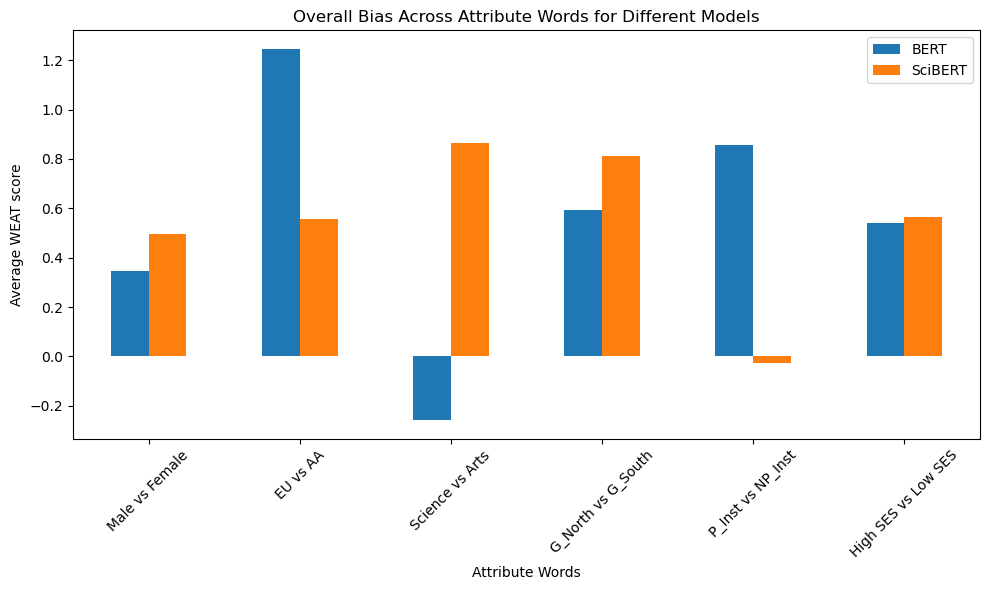

,BERT,SciBERT
Male vs Female,0.3448,0.4950
EU vs AA,1.2462,0.5568
Science vs Arts,-0.2578,0.8662
G_North vs G_South,0.5940,0.8120
P_Inst vs NP_Inst,0.8550,-0.0286
High SES vs Low SES,0.5418,0.5630


In [24]:
bias_across_attributes = combined_df.groupby(level=1, axis=1).mean()
plt.figure(figsize=(10, 6))
bias_across_attributes.plot(kind='bar', figsize=(10, 6))
plt.title('Overall Bias Across Attribute Words for Different Models')
plt.ylabel('Average WEAT score')
plt.xlabel('Attribute Words')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
bias_across_attributes

In [25]:
bias_across_attributes.mean()

BERT       0.554000
SciBERT    0.544067
dtype: float64